In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
train_data = MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

In [4]:
print(train_data)
print(test_data)
print(train_data.data.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])


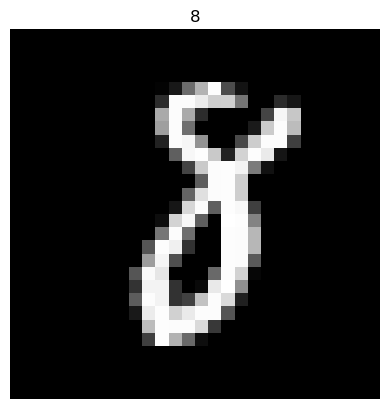

In [5]:
import matplotlib.pyplot as plt

plt.imshow(train_data.data[784], cmap='gray')
plt.title('%i' % train_data.targets[784])
plt.axis('off')
plt.show()

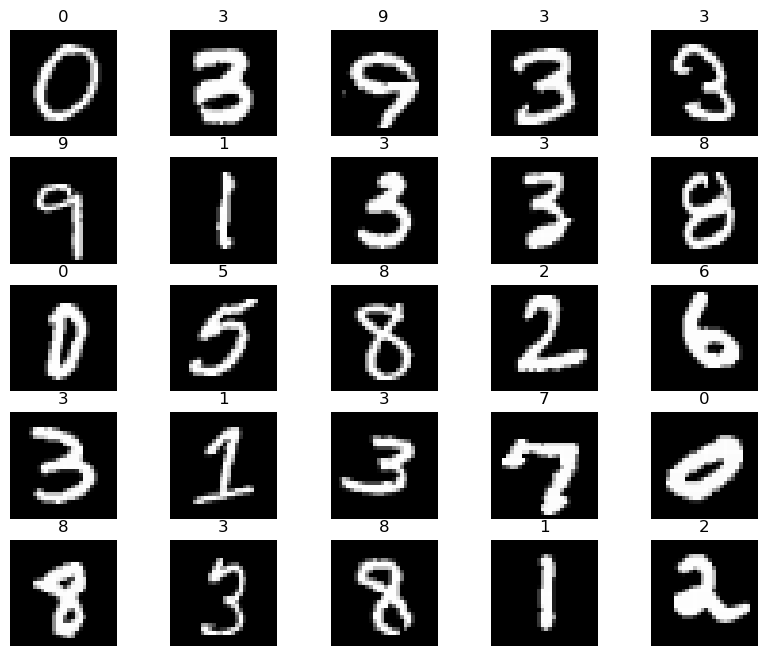

In [6]:
figure = plt.figure(figsize=(10, 8))
rows, cols = 5, 5
for i in range(1, rows*cols+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [8]:
# Define ResNet model
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=5,
            stride=1,
            padding=0
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(128, num_classes)
        
    def _make_layer(self, planes, blocks, stride=1):
        layers = []
        layers.append(nn.Conv2d(64, planes, kernel_size=1, stride=stride))
        layers.append(nn.BatchNorm2d(planes))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(planes, planes, kernel_size=3, padding=0))
        layers.append(nn.BatchNorm2d(planes))
        layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [9]:
# Initialize ResNet model
model = ResNet()

In [10]:
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Trainning model

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        correct_predictions = 0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predictions = torch.max(outputs, 1)
            correct_predictions += (predictions == labels).sum().item()
            
    # Calculate average validation loss and accuracy for each epoch
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    val_accuracy = correct_predictions / len(test_data) * 100
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

Epoch [1/10], Train Loss: 0.1282, Val Loss: 0.0326, Val Accuracy: 99.07%
Epoch [2/10], Train Loss: 0.0585, Val Loss: 0.0284, Val Accuracy: 99.08%
Epoch [3/10], Train Loss: 0.0295, Val Loss: 0.0221, Val Accuracy: 99.34%
Epoch [4/10], Train Loss: 0.0248, Val Loss: 0.0229, Val Accuracy: 99.28%
Epoch [5/10], Train Loss: 0.0222, Val Loss: 0.0241, Val Accuracy: 99.25%
Epoch [6/10], Train Loss: 0.0172, Val Loss: 0.0275, Val Accuracy: 99.06%
Epoch [7/10], Train Loss: 0.0165, Val Loss: 0.0268, Val Accuracy: 99.24%
Epoch [8/10], Train Loss: 0.0142, Val Loss: 0.0258, Val Accuracy: 99.22%
Epoch [9/10], Train Loss: 0.0120, Val Loss: 0.0311, Val Accuracy: 99.15%
Epoch [10/10], Train Loss: 0.0110, Val Loss: 0.0295, Val Accuracy: 99.15%


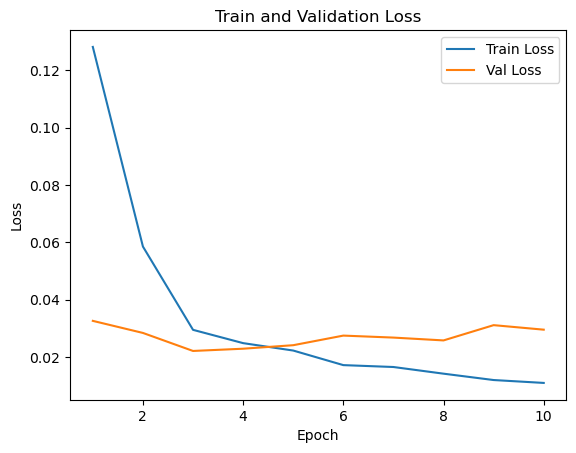

In [13]:
# Plot the losses
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [14]:
# Save ResNet model
torch.save(model.state_dict(), 'resnet_model.pt')

In [15]:
# Load pre_trained model weights
model.load_state_dict(torch.load('resnet_model.pt'))

<All keys matched successfully>

In [16]:
# Create data loader
batch_size = 1
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [17]:
# Evaluate on 15 random images
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [18]:
import random
random_idx = random.sample(range(len(test_data)), k=15)

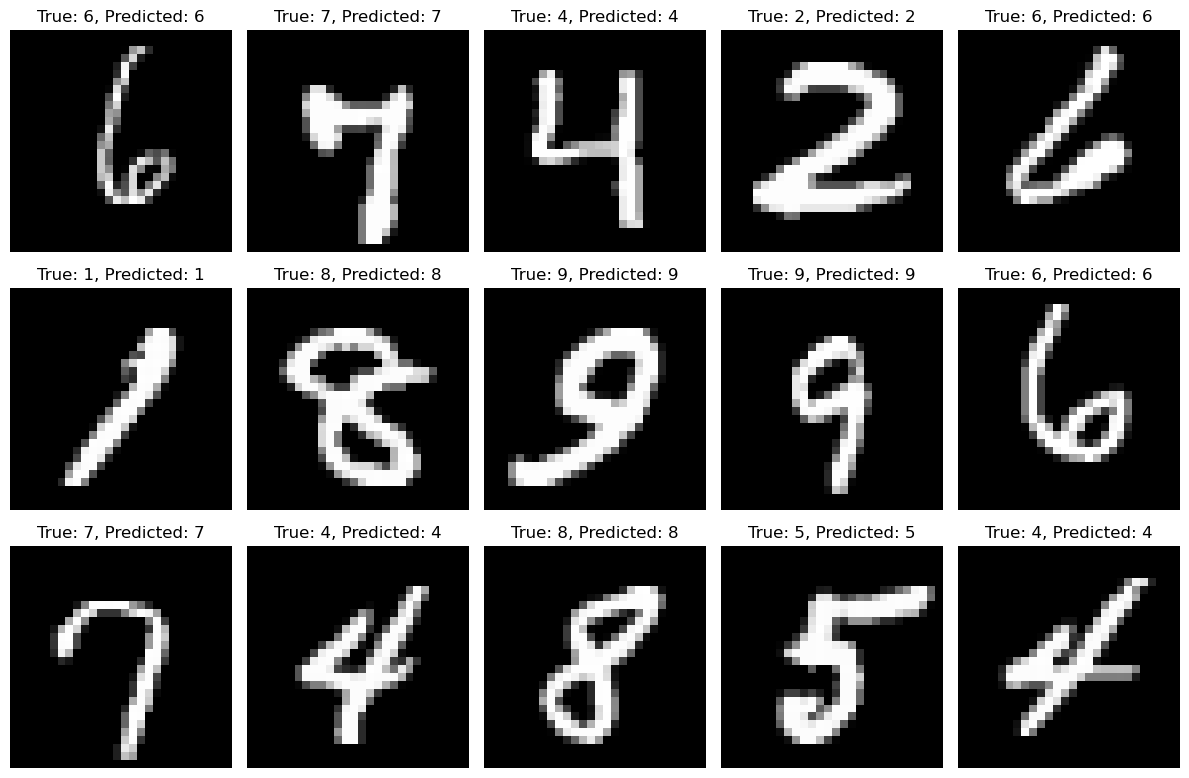

In [19]:
# Perform prediction on the selected images
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))

with torch.no_grad():
    for i, index in enumerate(random_idx):
        image, label = test_data[index]
        image = image.unsqueeze(0).to(device)
        
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        
        true_label = label
        predicted_label = predicted.item()
        
        # Convert tensor image to numpy array
        image = image.squeeze().cpu().numpy()
        
        # Plot the image
        ax = axes[i // 5, i % 5]
        ax.imshow(image, cmap='gray')
        ax.set_title(f'True: {true_label}, Predicted: {predicted_label}')
        ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [20]:
# Print the state_dict of the model
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([64, 1, 5, 5])
conv1.bias 	 torch.Size([64])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.weight 	 torch.Size([64, 64, 1, 1])
layer1.0.bias 	 torch.Size([64])
layer1.1.weight 	 torch.Size([64])
layer1.1.bias 	 torch.Size([64])
layer1.1.running_mean 	 torch.Size([64])
layer1.1.running_var 	 torch.Size([64])
layer1.1.num_batches_tracked 	 torch.Size([])
layer1.3.weight 	 torch.Size([64, 64, 3, 3])
layer1.3.bias 	 torch.Size([64])
layer1.4.weight 	 torch.Size([64])
layer1.4.bias 	 torch.Size([64])
layer1.4.running_mean 	 torch.Size([64])
layer1.4.running_var 	 torch.Size([64])
layer1.4.num_batches_tracked 	 torch.Size([])
layer2.0.weight 	 torch.Size([128, 64, 1, 1])
layer2.0.bias 	 torch.Size([128])
layer2.1.weight 	 torch.Size([128])
layer2.1.bias 	 torch.Size([128])
layer2.1.running_mean 	 torch.Size([128])
l

In [28]:
from torchviz import make_dot

# Create an instance of the model
model = ResNet()

# Generate a visualization of the model
x = torch.randn(1, 1, 28, 28)
dot = make_dot(model(x), params=dict(model.named_parameters()))
dot.render("model_graph")  # Save the visualization to a file

'model_graph.pdf'

In [40]:
!jupyter nbconvert --to webpdf --allow-chromium-download ResNetModel.ipynb

[NbConvertApp] Converting notebook ResNetModel.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 242386 bytes to ResNetModel.pdf
